## Capstone- Cancer Histopathology: Image Load Test

Dataset:
- A. Borkowski, "Lung and Colon Cancer Histopathological Images", Kaggle.com, 2020. [Online]. Available: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images. [Accessed: 30- Jul- 2022].

Sources:
- Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

Image Labels:
- Lung benign tissue: 0
- Lung adenocarcinoma: 1
- Lung squamous cell carcinoma: 2
- Colon adenocarcinoma: 3
- Colon benign tissue: 4

### Import Libraries

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import re as regex
import spacy
from pathlib import Path
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import string
from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Data

In [2]:
import PIL
from PIL import Image
import glob
import os, os.path
from numpy import asarray

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [135]:
# check Pillow version number
print('Pillow Version:', PIL.__version__)

Pillow Version: 9.1.0


In [136]:
image_list= []
for filename in glob.glob('./lung_colon_image_set/testImageSet/*.jpeg'): #assuming jpeg
    im= Image.open(filename)
    image_list.append(im)
image_list

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>]

In [137]:
imgs= []
path= "./lung_colon_image_set/testImageSet/"
valid_images= ["jpeg", ".jpg", ".gif", ".png", ".tga"]
for f in os.listdir(path):
    ext= os.path.splitext(f)[1]
    if ext.lower() in valid_images:
        continue
    imgs.append(Image.open(os.path.join(path,f)))
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>]

#### Convert images to numpy array

In [156]:
imgArrData01= []
for i in image_list:
    print(i)
    data= asarray(i)
    imgArrData01.append(data)
imgArrData01

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D6320>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D7310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D6110>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D5270>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D7C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D7700>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D7640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D77F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D7FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D4F10>


[array([[[255, 235, 234],
         [255, 236, 235],
         [255, 229, 234],
         ...,
         [220, 178, 228],
         [218, 176, 226],
         [210, 168, 218]],
 
        [[253, 233, 234],
         [255, 234, 236],
         [255, 230, 235],
         ...,
         [215, 172, 225],
         [213, 170, 223],
         [205, 162, 215]],
 
        [[251, 230, 235],
         [255, 232, 238],
         [255, 229, 239],
         ...,
         [212, 169, 223],
         [208, 165, 219],
         [200, 157, 211]],
 
        ...,
 
        [[250, 209, 253],
         [252, 211, 255],
         [254, 211, 254],
         ...,
         [249, 197, 235],
         [248, 196, 234],
         [249, 197, 235]],
 
        [[249, 207, 253],
         [251, 210, 254],
         [253, 210, 253],
         ...,
         [255, 200, 239],
         [252, 197, 236],
         [249, 194, 233]],
 
        [[245, 203, 249],
         [247, 206, 250],
         [251, 208, 253],
         ...,
         [255, 204, 243],
  

In [139]:
imgArrData01[0].shape

(768, 768, 3)

In [154]:
imgArrData02= []
for i in image_list:
    print(i)
    data= img_to_array(i)
    imgArrData02.append(data)
imgArrData02

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D6320>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D7310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D6110>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D5270>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D7C40>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D7700>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D7640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D77F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D7FA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x223921D4F10>


[array([[[255., 235., 234.],
         [255., 236., 235.],
         [255., 229., 234.],
         ...,
         [220., 178., 228.],
         [218., 176., 226.],
         [210., 168., 218.]],
 
        [[253., 233., 234.],
         [255., 234., 236.],
         [255., 230., 235.],
         ...,
         [215., 172., 225.],
         [213., 170., 223.],
         [205., 162., 215.]],
 
        [[251., 230., 235.],
         [255., 232., 238.],
         [255., 229., 239.],
         ...,
         [212., 169., 223.],
         [208., 165., 219.],
         [200., 157., 211.]],
 
        ...,
 
        [[250., 209., 253.],
         [252., 211., 255.],
         [254., 211., 254.],
         ...,
         [249., 197., 235.],
         [248., 196., 234.],
         [249., 197., 235.]],
 
        [[249., 207., 253.],
         [251., 210., 254.],
         [253., 210., 253.],
         ...,
         [255., 200., 239.],
         [252., 197., 236.],
         [249., 194., 233.]],
 
        [[245., 203., 249.],
 

In [155]:
imgArrData02.shape

AttributeError: 'list' object has no attribute 'shape'

#### Convert images from numpy array to image

In [142]:
imgListArr01= []
for i in imgArrData01:
#     print(i)
    image= Image.fromarray(i)
    imgListArr01.append(image)
imgListArr01

[<PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>]

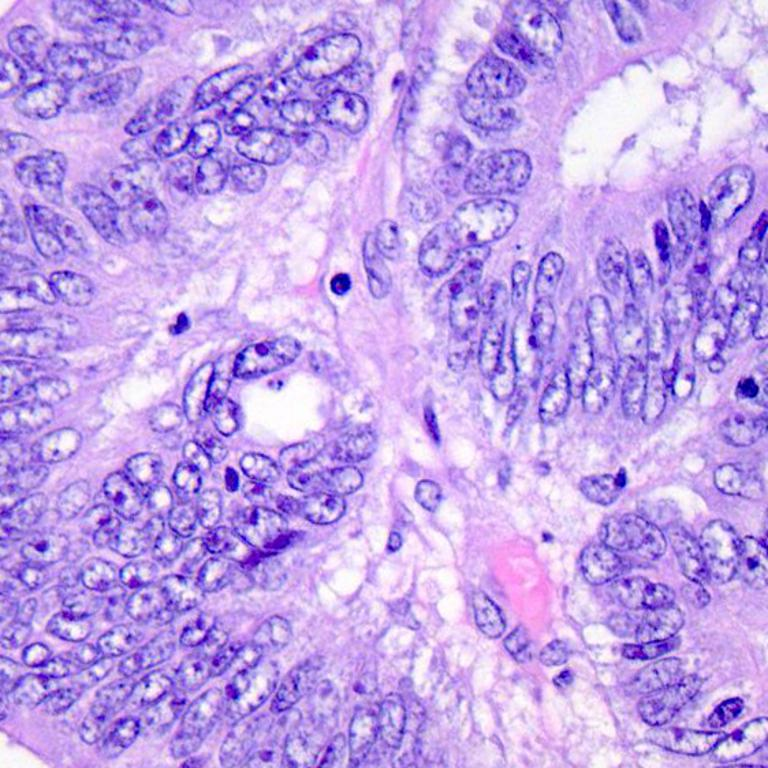

In [143]:
imgListArr01[1]

In [144]:
imgListArr02= []
for i in imgArrData01:
#     print(i)
    image= array_to_img(i)
    imgListArr02.append(image)
imgListArr02

[<PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>,
 <PIL.Image.Image image mode=RGB size=768x768>]

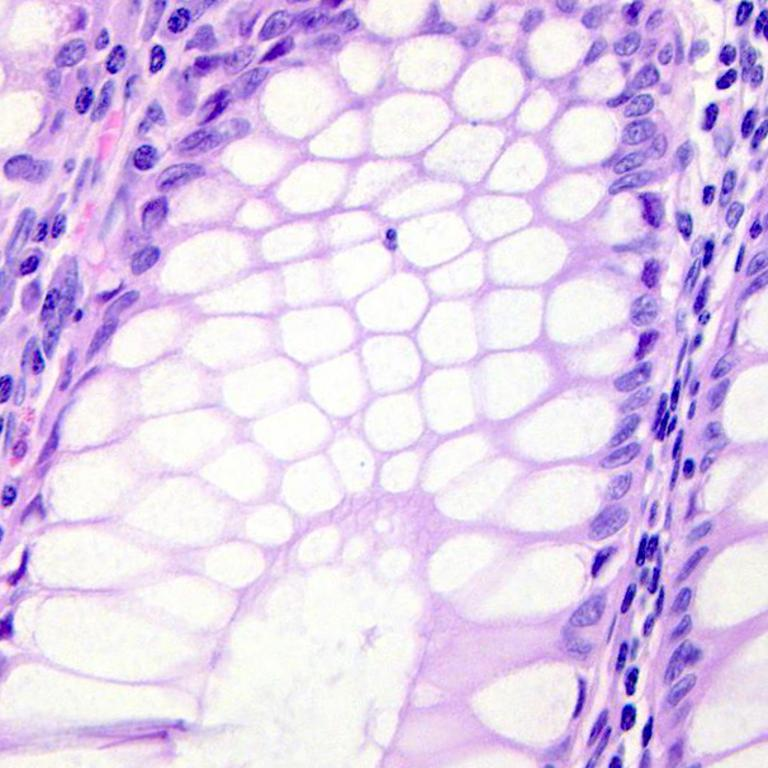

In [145]:
imgListArr02[2]

#### Resizing images

In [146]:
rzDataArr01= []
for i in imgListArr01:
    print(i)
    rzImage= np.array(i.resize((255,255)))
    rzDataArr01.append(rzImage)
rzDataArr01

<PIL.Image.Image image mode=RGB size=768x768 at 0x22391169F00>
<PIL.Image.Image image mode=RGB size=768x768 at 0x2239116B850>
<PIL.Image.Image image mode=RGB size=768x768 at 0x2239116ADA0>
<PIL.Image.Image image mode=RGB size=768x768 at 0x2239116AD70>
<PIL.Image.Image image mode=RGB size=768x768 at 0x2239116A2F0>
<PIL.Image.Image image mode=RGB size=768x768 at 0x2239116A590>
<PIL.Image.Image image mode=RGB size=768x768 at 0x2239116B8E0>
<PIL.Image.Image image mode=RGB size=768x768 at 0x223C11EE9E0>
<PIL.Image.Image image mode=RGB size=768x768 at 0x223921D7CA0>
<PIL.Image.Image image mode=RGB size=768x768 at 0x223921D5CC0>


[array([[[254, 232, 236],
         [252, 210, 230],
         [242, 183, 232],
         ...,
         [213, 172, 216],
         [206, 163, 213],
         [211, 168, 220]],
 
        [[253, 228, 242],
         [251, 208, 235],
         [242, 181, 234],
         ...,
         [216, 175, 220],
         [215, 172, 226],
         [216, 173, 232]],
 
        [[251, 221, 246],
         [252, 205, 239],
         [238, 176, 231],
         ...,
         [217, 178, 223],
         [218, 177, 236],
         [216, 174, 240]],
 
        ...,
 
        [[249, 207, 243],
         [243, 201, 238],
         [239, 199, 236],
         ...,
         [252, 203, 242],
         [246, 199, 237],
         [239, 193, 230]],
 
        [[252, 210, 251],
         [248, 206, 242],
         [249, 208, 240],
         ...,
         [252, 199, 237],
         [252, 202, 239],
         [250, 201, 238]],
 
        [[250, 208, 253],
         [254, 212, 250],
         [255, 215, 247],
         ...,
         [249, 193, 232],
  

In [147]:
rzData= np.array(rzDataArr01)

In [148]:
rzData.shape

(10, 255, 255, 3)

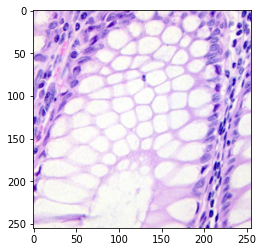

In [149]:
plt.imshow(rzData[2])

In [150]:
rzListArr01= []
for i in rzData:
#     print(i)
    image= Image.fromarray(i)
    rzListArr01.append(image)
rzListArr01

[<PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>]

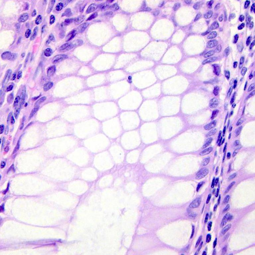

In [151]:
rzListArr01[2]

In [152]:
rzListArr02= []
for i in rzData:
#     print(i)
    image= array_to_img(i)
    rzListArr02.append(image)
rzListArr02

[<PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>,
 <PIL.Image.Image image mode=RGB size=255x255>]

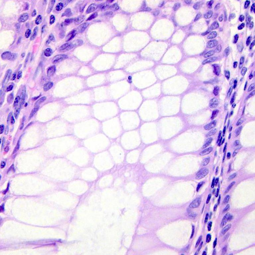

In [153]:
rzListArr02[2]